In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.datasets import make_sparse_spd_matrix

In [2]:
def GABP_t(AMat, BMat, lam):
    """
    Function that implements Gaussian belief propagation
    Inputs:
        AMat: precision matrix
        BMat: time series of bias vectors
        lam: relaxation for updates, between 0 and 1
        p(x) = k.exp(-0.5x'Ax + b'x)
   
    Outputs: 
        InferredPrec: vector of marginal precisions
        InferredBias: vector of marginal biases    
        InferredPrecMat: time series of marginal precisions
        InferredBiasMat: time series of marginal biases
    """
    
    N, T = BMat.shape  
    Ad = (AMat != 0)*1 - np.eye(N) #adjacency matrix 
    
    # initialize the precision and biases of the messages
    # P[i,j] corresponds to message sent from node i to node j
    P = (0.4*np.random.rand(N,N)-0.2)*Ad #initialize the precisions with some noise
    V    = np.zeros([N,N])
    
    Pnew = np.zeros([N,N])
    Vnew = np.zeros([N,N])
    
    eps = 1e-6 #tolerance for convergence
    
    InferredPrec    = np.zeros([N])
    InferredBias    = np.zeros([N])
    InferredPrecMat = np.zeros([N,T])
    InferredBiasMat = np.zeros([N,T])
    

    for t in range(T):
        BVec = BMat[:,t]
        for i in range(N):
            for j in range(N):
                if Ad[i,j]:
                    # update message parameters
                    alpha = AMat[i,i] + np.sum(P[:,i]) - P[j,i]
                    beta = BVec[i] + np.sum(V[:,i]) - V[j,i]
                    Pnew[i,j] = (1-lam)*P[i,j] -lam*AMat[i,j]**2/alpha
                    Vnew[i,j] = (1-lam)*V[i,j] -lam*AMat[i,j]*beta/alpha
                    
        # now compute the beliefs
        InferredPrec = np.diag(AMat) + np.sum(Pnew,axis=0)
        InferredBias = BVec + np.sum(Vnew,axis=0)
        InferredPrecMat[:,t] = 1*InferredPrec
        InferredBiasMat[:,t] = 1*InferredBias
            
        P = 1*Pnew
        V = 1*Vnew 

        
    return InferredPrecMat, InferredBiasMat

def generateBroadH(Nx,T,Tb,scaling):
    """
    Function to generate b(t), 
    Modeling b(t) such that it stays constant for every Tb time steps.
    """    

    # first generate only T/Nh independent values of b
    shape = 2 # gamma shape parameter
    Lb = np.int(T//Tb)
    gsmScale = np.random.gamma(shape,scaling,(Nx,Lb))
    bInd = gsmScale*np.random.randn(Nx,Lb)
    bMat = np.zeros([Nx,T])

    # Then repeat each independent h for Nh time steps
    for t in range(T):
        bMat[:,t] = bInd[:,np.int(t//Tb)]
        
    return bMat

In [3]:
# Set noise seed
noise_seed = np.random.randint(10000)
print('noise_seed =', noise_seed)
np.random.seed(seed=noise_seed)

# Generate data using Gaussian Belief Propagation

B = 50 # No. of batches
T = 60 # Total no. of time steps in each bactch
Tb = 20 # No. of time steps to keep the inputs/bias constant
scale = 1 #input scale

# Filter for input signal
f = signal.hamming(3,sym=True) 
f = f/sum(f)

# Create the precision matrix. This will be fixed for all the batches
N = 25 # no. of variables
AMat = make_sparse_spd_matrix(dim=N, alpha=0.8, smallest_coef=0.1,largest_coef=0.25) # random, sparse precision matrix 

Data = np.zeros([B,2,N,T])

# Run GABP
for b in range(B):   
    BMat = signal.filtfilt(f,1,generateBroadH(N,T,Tb,scale))
    InferredPrecMat, InferredBiasMat = GABP_t(AMat, BMat, lam=0.25)
    Data[b,0,:,:] = InferredPrecMat
    Data[b,1,:,:] = InferredBiasMat


noise_seed = 6595


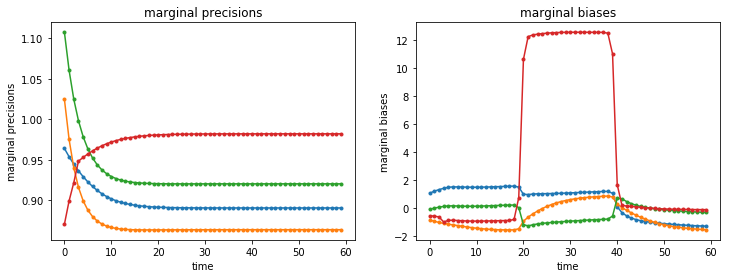

Marginal precisions do not depend on the input signal/bias for Gaussian BP.
They depend only on the precision matrix.
The biases, however, depend on the inputs, which is why you see significant changes every Tb time-steps.


In [4]:
# Example plots
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Data[0,0,0:4,:].T,'.-')
ax[0].set(xlabel='time', ylabel='marginal precisions', title = 'marginal precisions')
ax[1].plot(Data[0,1,0:4,:].T,'.-')
ax[1].set(xlabel='time', ylabel='marginal biases', title = 'marginal biases')
plt.show()

print('Marginal precisions do not depend on the input signal/bias for Gaussian BP.')
print('They depend only on the precision matrix.')
print('The biases, however, depend on the inputs, which is why you see significant changes every Tb time-steps.')

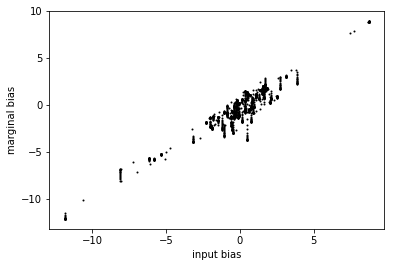

In [5]:
# figure comparing the marginal biases with the input biases
plt.plot(BMat.flatten(),Data[-1,1,:,:].flatten(), 'k.',markersize =2)
plt.xlabel('input bias')
plt.ylabel('marginal bias')
plt.show()